# Créer un algorithme de détection des faux billets
## 1. Analyses univariées et bivariées
## 2. Analyse en Composantes Principales
## 3. Algorithme de classification
## 4. Regression logistique
## 5. Programme de prediction

### Importation des données et des bibliothèques

In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy.cluster.hierarchy as sch
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import decomposition, preprocessing
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pylab import rcParams
rcParams['figure.figsize'] = 12,6


In [2]:
# Creation des fonctions
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            
            #an = np.linspace(0, 2 * np.pi, 100)
            #plt.plot(np.cos(an), np.sin(an))

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, cmap='veridis'):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, cmap='veridis')
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

In [3]:
# Importation des données
data = pd.read_csv("/Users/teilo/Desktop/OC - Projet 6/detectez_faux_billets/Données/notes.csv")
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,False,172.11,104.23,104.45,5.24,3.58,111.78
166,False,173.01,104.59,104.31,5.04,3.05,110.91
167,False,172.47,104.27,104.10,4.88,3.33,110.68
168,False,171.82,103.97,103.88,4.73,3.55,111.87


## 1. Analyses (univariées et bivariées)

### Recherche des valeurs nulles

In [4]:
display(data.isna().sum())
display(data[data<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Aucune valeur nulle ou négative. Aucune donnée NaN non plus.

### Analyses

In [5]:
# Eta^2 
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

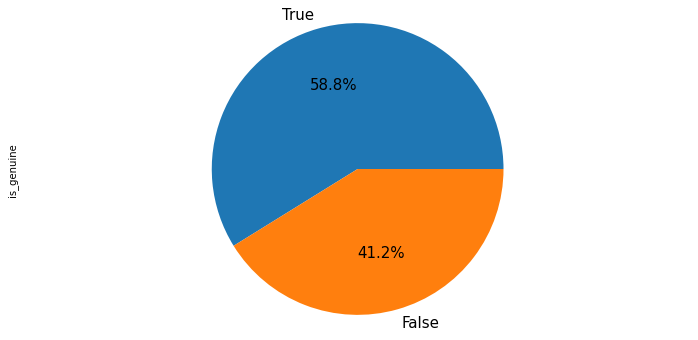

In [6]:
# Diagramme en secteurs
data["is_genuine"].value_counts(normalize=True).plot(kind='pie', autopct= '%1.1f%%', textprops={'fontsize':15})
plt.axis('equal') 
plt.show()

##### Analyse de la diagonale

Est un vrai billet : True
Moyenne: 171.97610000000003
Medianne: 172.005
Minimal: 171.04
Maximal: 172.75


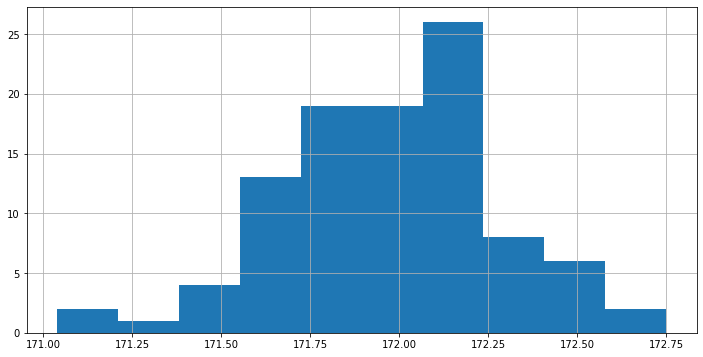

Est un vrai billet : False
Moyenne: 171.88985714285712
Medianne: 171.875
Minimal: 171.38
Maximal: 173.01


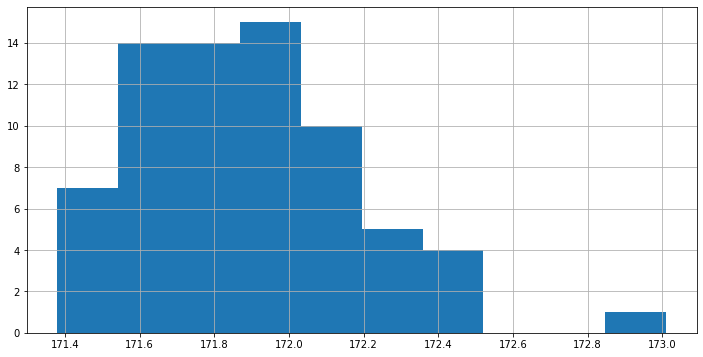

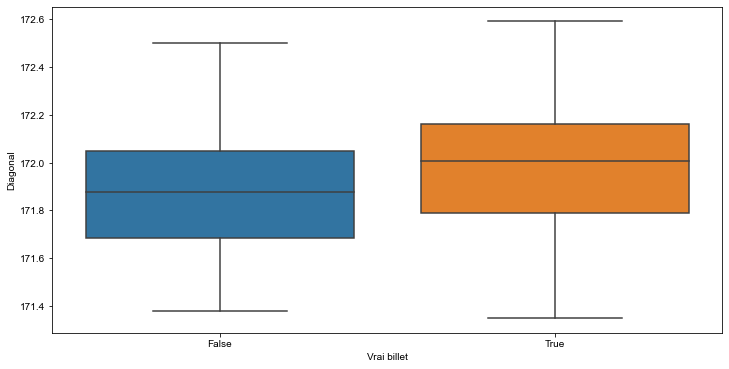

Eta^2 = 0.019383108567093802


In [7]:
# Analyse de la diagonale
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['diagonal'].mean())
    print("Medianne:",subset['diagonal'].median())
    print("Minimal:", subset['diagonal'].min())
    print("Maximal:", subset['diagonal'].max())
    subset["diagonal"].hist() 
    plt.show() 
    
sns_plot = sns.boxplot(x='is_genuine', y='diagonal', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("Diagonal")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['diagonal']))

Les vrais billets ont une diagonale moyenne (172.97 > 171.88) et medianne (172 > 171.87) plus grande que les faux billets.

##### Analyse de height_left

Est un vrai billet : True
Moyenne: 103.95149999999998
Medianne: 103.91499999999999
Minimal: 103.23
Maximal: 104.86


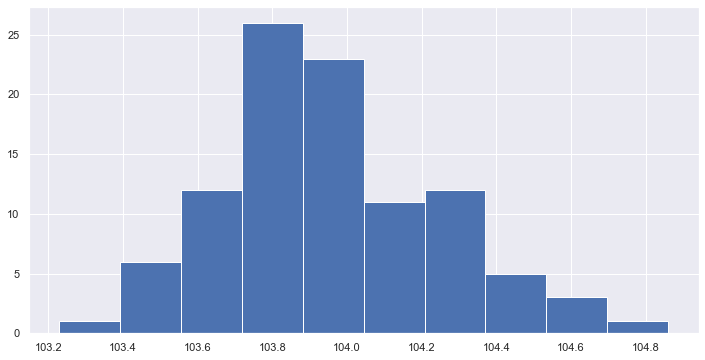

Est un vrai billet : False
Moyenne: 104.23042857142856
Medianne: 104.215
Minimal: 103.78
Maximal: 104.72


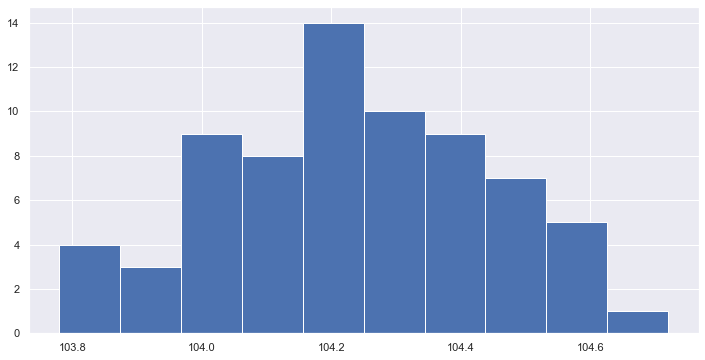

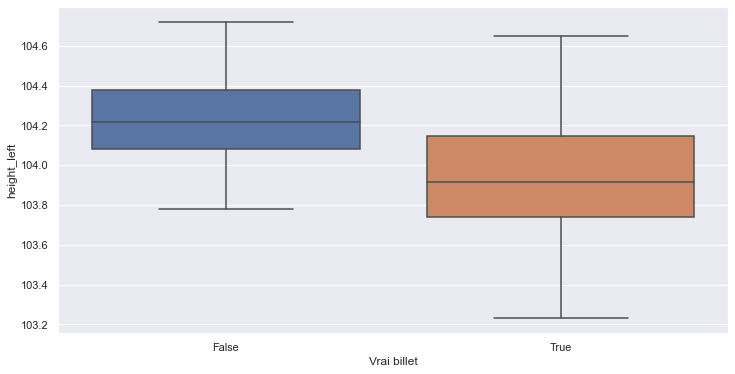

Eta^2 = 0.21319458315018705


In [8]:
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['height_left'].mean())
    print("Medianne:",subset['height_left'].median())
    print("Minimal:", subset['height_left'].min())
    print("Maximal:", subset['height_left'].max())
    subset["height_left"].hist() 
    plt.show() 
    
sns_plot = sns.boxplot(x='is_genuine', y='height_left', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("height_left")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['height_left']))

Les billets ont généralement une plus petit taille sur le coté gauche que les faux.

##### Analyse de height_right

Est un vrai billet : True
Moyenne: 103.77590000000002
Medianne: 103.76
Minimal: 103.14
Maximal: 104.95


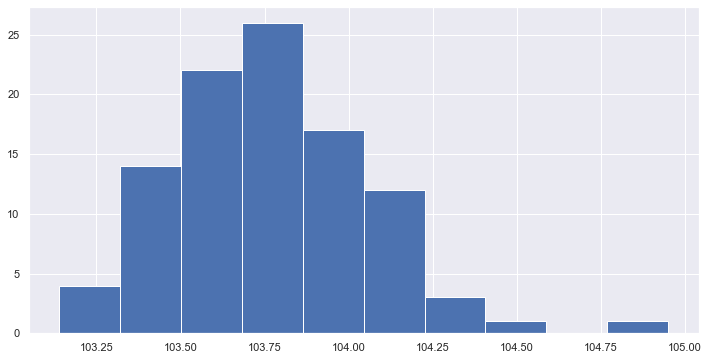

Est un vrai billet : False
Moyenne: 104.14557142857143
Medianne: 104.17
Minimal: 103.44
Maximal: 104.86


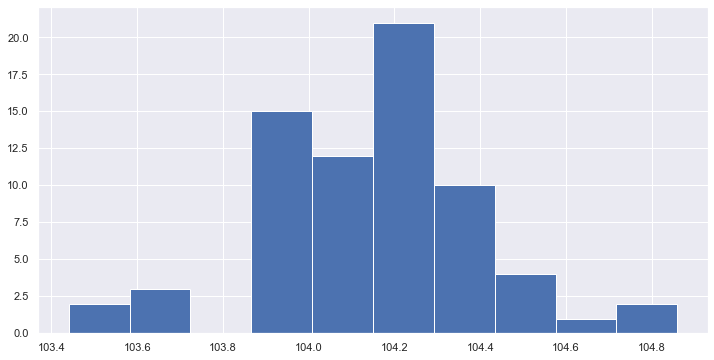

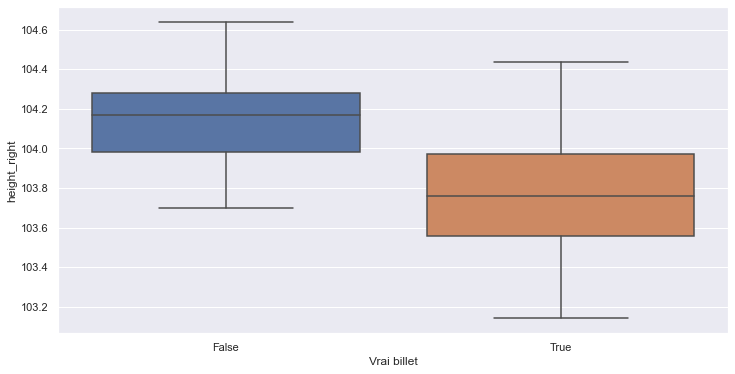

Eta^2 = 0.30394154672012125


In [9]:
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['height_right'].mean())
    print("Medianne:",subset['height_right'].median())
    print("Minimal:", subset['height_right'].min())
    print("Maximal:", subset['height_right'].max())
    subset["height_right"].hist() 
    plt.show() 
    
sns_plot = sns.boxplot(x='is_genuine', y='height_right', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("height_right")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['height_right']))

Les billets ont généralement une plus petit taille sur le coté droite que les faux.

##### Analyse de margin_low

Est un vrai billet : True
Moyenne: 4.143500000000002
Medianne: 4.08
Minimal: 3.54
Maximal: 5.04


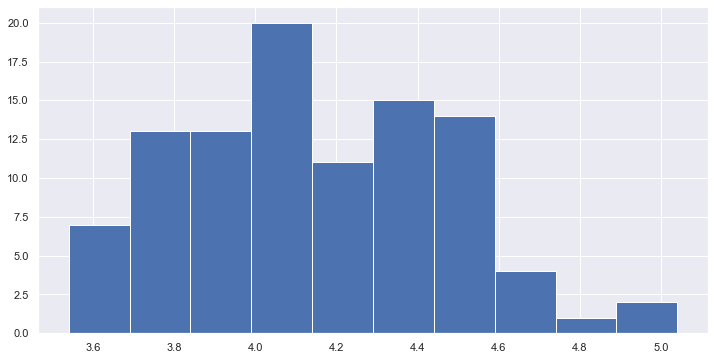

Est un vrai billet : False
Moyenne: 5.281571428571428
Medianne: 5.265
Minimal: 3.82
Maximal: 6.28


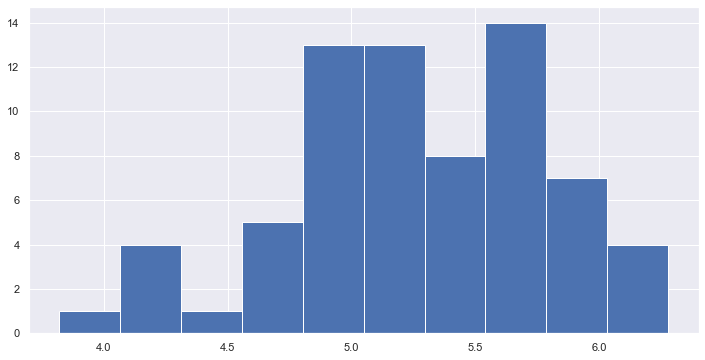

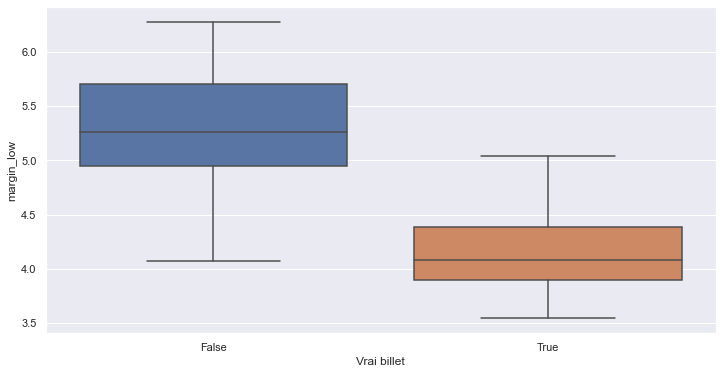

Eta^2 = 0.640177214288775


In [10]:
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['margin_low'].mean())
    print("Medianne:",subset['margin_low'].median())
    print("Minimal:", subset['margin_low'].min())
    print("Maximal:", subset['margin_low'].max())
    subset["margin_low"].hist() 
    plt.show() 

sns_plot = sns.boxplot(x='is_genuine', y='margin_low', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("margin_low")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['margin_low']))

La marge basse est en moyenne plus petite dans les vraies billets plutot que dans les faux.

##### Analyse de margin_up

Est un vrai billet : True
Moyenne: 3.0555000000000003
Medianne: 3.07
Minimal: 2.27
Maximal: 3.53


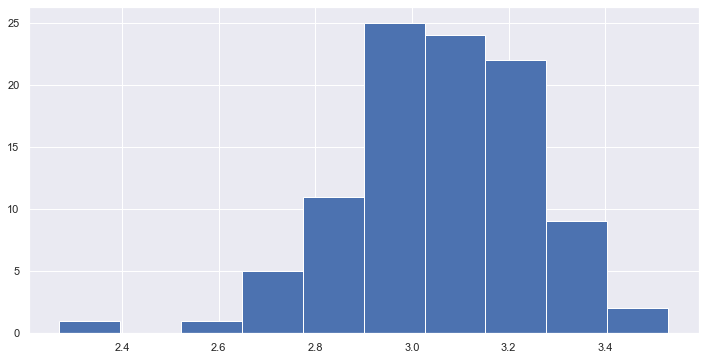

Est un vrai billet : False
Moyenne: 3.3345714285714294
Medianne: 3.335
Minimal: 2.98
Maximal: 3.68


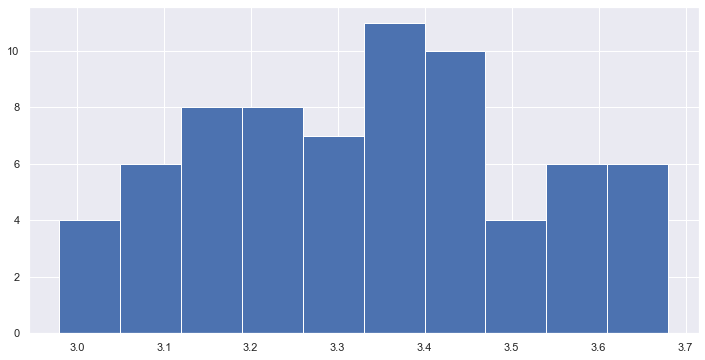

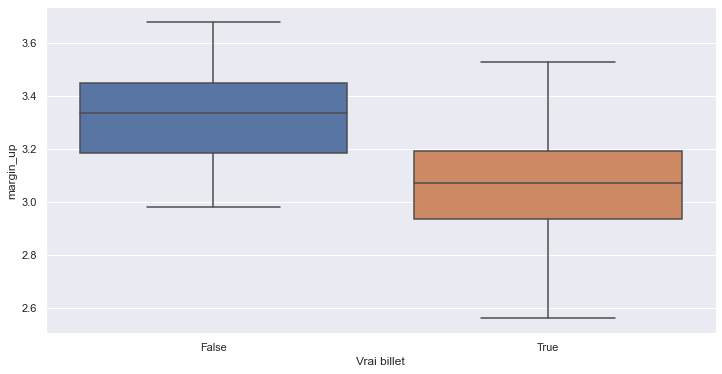

Eta^2 = 0.3396567096032002


In [11]:
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['margin_up'].mean())
    print("Medianne:",subset['margin_up'].median())
    print("Minimal:", subset['margin_up'].min())
    print("Maximal:", subset['margin_up'].max())
    subset["margin_up"].hist() 
    plt.show() 
    
sns_plot = sns.boxplot(x='is_genuine', y='margin_up', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("margin_up")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['margin_up']))

La marge haute d'un vrai billet est en moyenne plus petite que dans un vrai.

##### Analyse de length

Est un vrai billet : True
Moyenne: 113.20720000000001
Medianne: 113.21
Minimal: 111.76
Maximal: 113.98


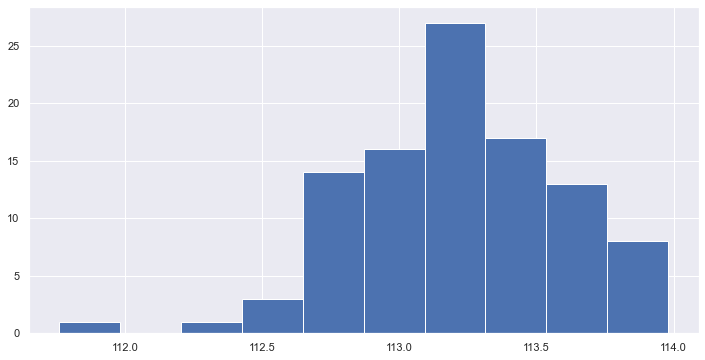

Est un vrai billet : False
Moyenne: 111.6607142857143
Medianne: 111.765
Minimal: 109.97
Maximal: 113.64


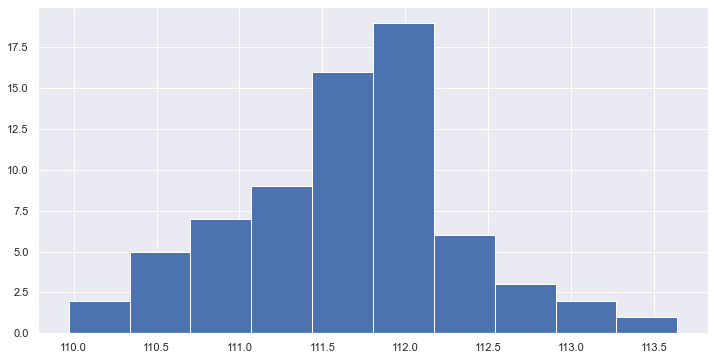

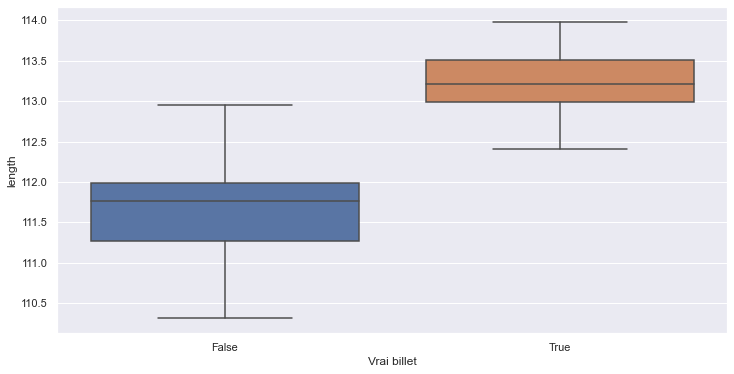

Eta^2 = 0.6818507654957807


In [12]:
for cat in data["is_genuine"].unique():
    subset = data[data.is_genuine == cat]
    print("Est un vrai billet :",cat)
    print("Moyenne:",subset['length'].mean())
    print("Medianne:",subset['length'].median())
    print("Minimal:", subset['length'].min())
    print("Maximal:", subset['length'].max())
    subset["length"].hist() 
    plt.show() 
    
sns_plot = sns.boxplot(x='is_genuine', y='length', data=data,showfliers=False)
sns.set_theme()
plt.xlabel("Vrai billet")
plt.ylabel("length")
plt.show()

print("Eta^2 =", eta_squared(data['is_genuine'], data['length']))

La taille des billets est en moyenne plus grande que les faux billets.

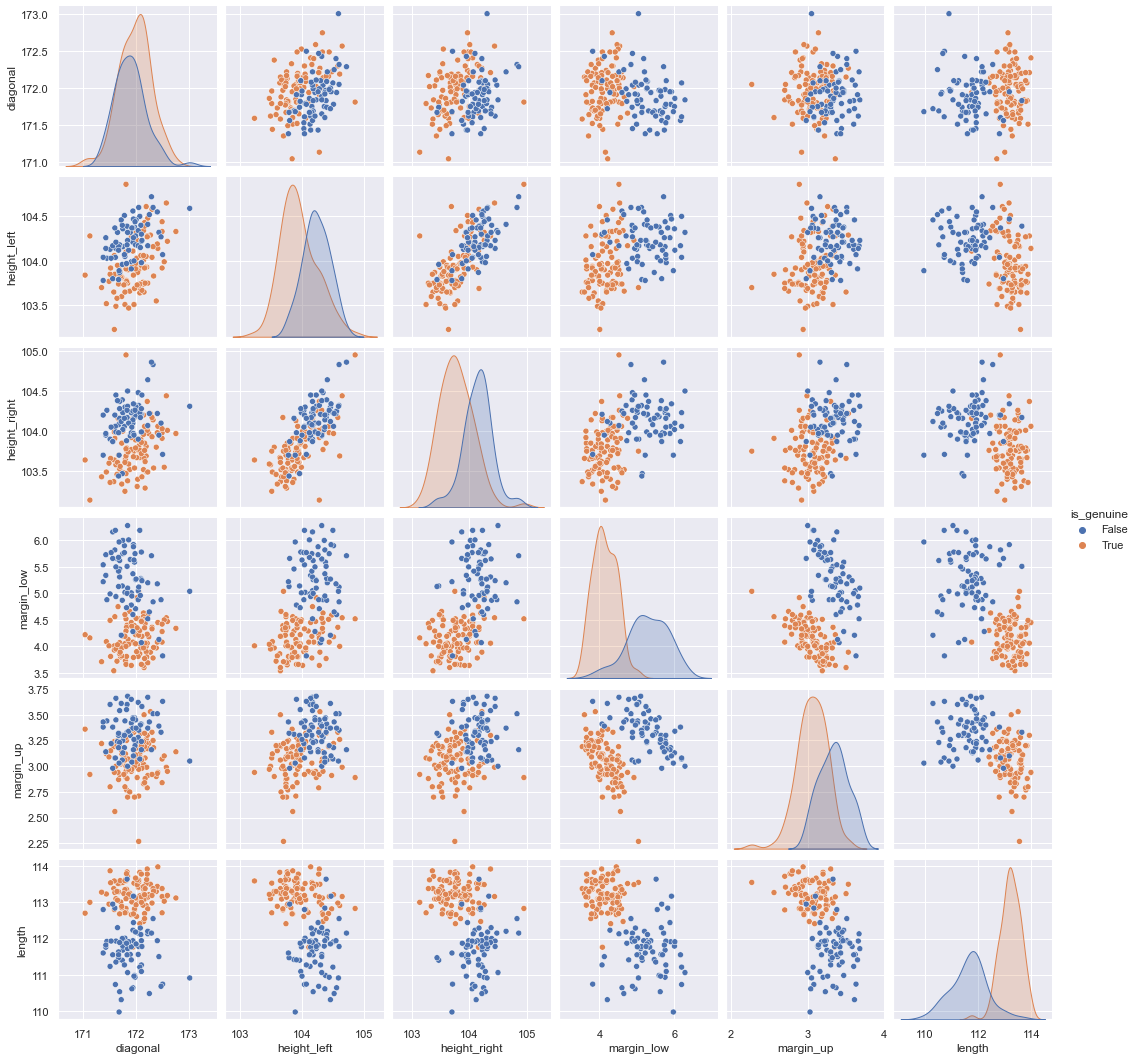

In [13]:
sns.pairplot(data, hue='is_genuine')

#### Changement des valeurs booléennes ( True & False) vers des valeurs (1 & 0)

In [14]:
data['is_genuine'] = data['is_genuine'].astype('uint8')
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.67,103.74,103.70,4.01,2.87,113.29
2,1,171.83,103.76,103.76,4.40,2.88,113.84
3,1,171.80,103.78,103.65,3.73,3.12,113.63
4,1,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,0,172.11,104.23,104.45,5.24,3.58,111.78
166,0,173.01,104.59,104.31,5.04,3.05,110.91
167,0,172.47,104.27,104.10,4.88,3.33,110.68
168,0,171.82,103.97,103.88,4.73,3.55,111.87


## 2. Analyse en Composantes Principales

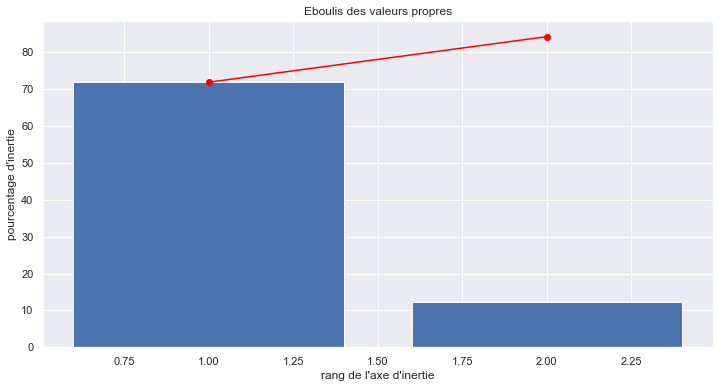

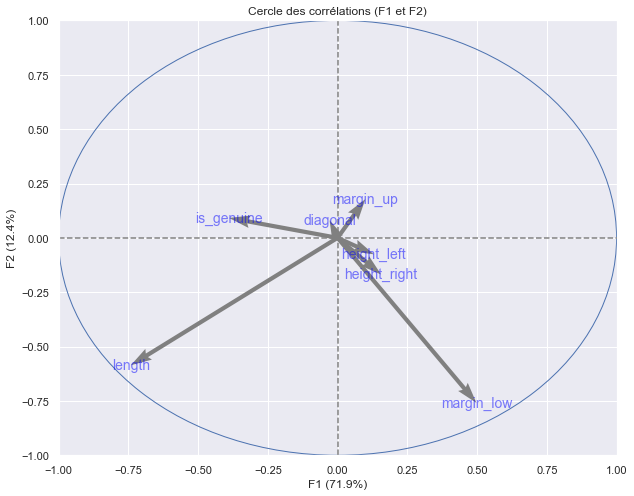

In [15]:
# PCA

# valeurs
datas = data.values
names = data.index
features = data.columns
n_comp = 2

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(datas)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcas = pca.components_
display_circles(pcas, n_comp, pca,[(0,1),(2,3),(4,5)], labels= np.array(features))
plt.show()

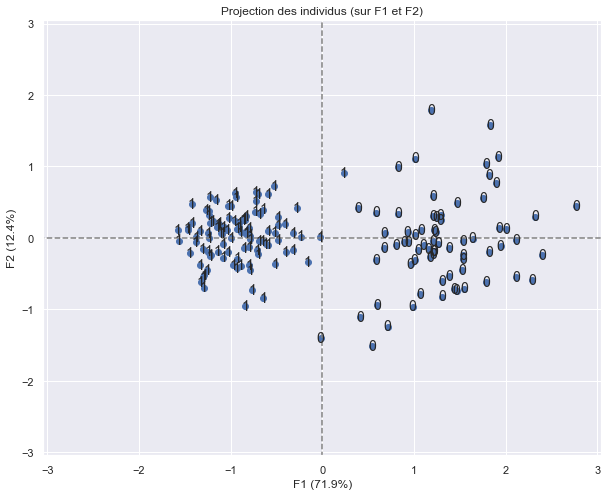

In [16]:
# Projection des individus
X_projected = pca.transform(datas)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = data['is_genuine'])
                         
plt.show()

On peut determiner un cluster homogène négative à F1 (gauche) et a contrario un cluster plus séparer corrélé positivement à celui-ci sur la droite.

## 3. Algorithme de classification
K-Means

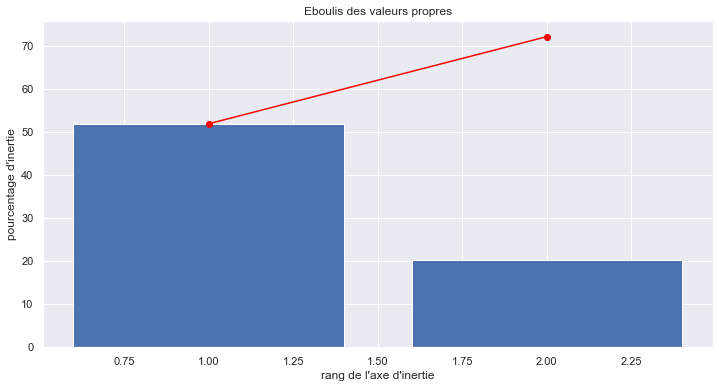

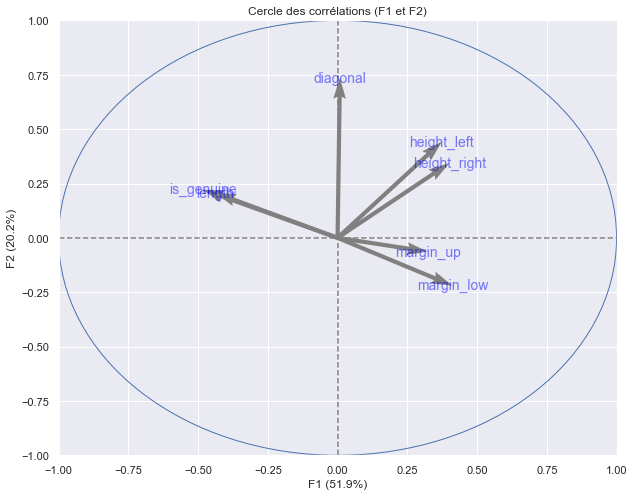

In [17]:
n_comp = 2

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data

# préparation des données pour l'ACP
#data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

plt.show()

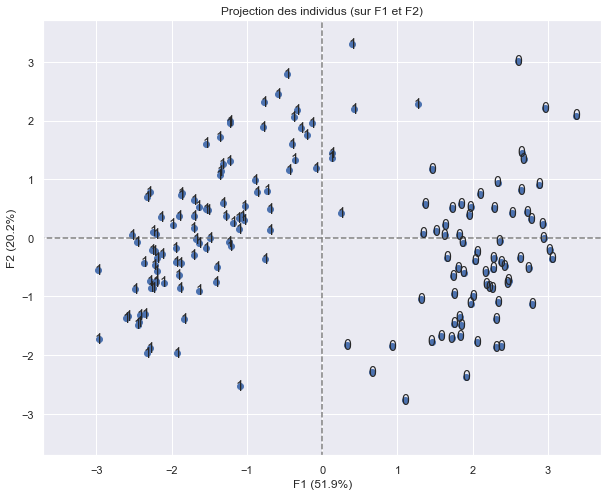

In [18]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], labels = data['is_genuine'])
                         
plt.show()

On voit bien que sur la projection, les vrai billets (gauche) et les faux (droite) sont bien séparés.

### Ajout des composantes au dataframe

In [19]:
'''
data['f1'] = X_projected[:,0]
data['f2'] = X_projected[:,1]
data

'''

"\ndata['f1'] = X_projected[:,0]\ndata['f2'] = X_projected[:,1]\ndata\n\n"

## 4. Regression logistique

In [20]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.67,103.74,103.70,4.01,2.87,113.29
2,1,171.83,103.76,103.76,4.40,2.88,113.84
3,1,171.80,103.78,103.65,3.73,3.12,113.63
4,1,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,0,172.11,104.23,104.45,5.24,3.58,111.78
166,0,173.01,104.59,104.31,5.04,3.05,110.91
167,0,172.47,104.27,104.10,4.88,3.33,110.68
168,0,171.82,103.97,103.88,4.73,3.55,111.87


In [21]:
# test train split
x_train, x_test, y_train, y_test = train_test_split(data.drop('is_genuine', axis=1), data['is_genuine'])

In [22]:
# train the model
LogReg = LogisticRegression(penalty='none',solver='newton-cg')
LogReg.fit(x_train,y_train)

LogisticRegression(penalty='none', solver='newton-cg')

In [23]:
# Score de l'algorithme
LogReg.score(x_test,y_test)

0.9767441860465116

In [24]:
# For the score
prediction = (LogReg.predict(x_test) >= .5).astype(int)
np.sum(prediction == y_test) /len(y_test)

0.9767441860465116

Vérification

In [29]:
y = data['is_genuine']
y

0      1
1      1
2      1
3      1
4      1
      ..
165    0
166    0
167    0
168    0
169    0
Name: is_genuine, Length: 170, dtype: uint8

In [30]:
x = data.drop(columns='is_genuine')
x

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.67,103.74,103.70,4.01,2.87,113.29
2,171.83,103.76,103.76,4.40,2.88,113.84
3,171.80,103.78,103.65,3.73,3.12,113.63
4,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...
165,172.11,104.23,104.45,5.24,3.58,111.78
166,173.01,104.59,104.31,5.04,3.05,110.91
167,172.47,104.27,104.10,4.88,3.33,110.68
168,171.82,103.97,103.88,4.73,3.55,111.87


In [31]:
pd.DataFrame(np.concatenate([LogReg.intercept_.reshape(-1,1),
                             LogReg.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(x.columns)).T

,coef
constante,-0.367811
diagonal,-4.083446
height_left,9.972282
height_right,-18.371484
margin_low,-31.113058
margin_up,-57.733666
length,16.930667


In [32]:
#importation des outils
from sklearn import preprocessing
import sklearn.metrics as metrics
#instanciation
stds = preprocessing.StandardScaler()
#transformation
ZTrain = stds.fit_transform(x)


In [37]:
#transformation de l'échantillon test
ZTest = stds.transform(x)
predSk = LogReg.predict(ZTest)

In [38]:
#rapport sur la qualité de prédiction
print(metrics.classification_report(y,predSk))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95        70
           1       0.99      0.93      0.96       100

    accuracy                           0.95       170
   macro avg       0.95      0.96      0.95       170
weighted avg       0.96      0.95      0.95       170



In [25]:
data

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.67,103.74,103.70,4.01,2.87,113.29
2,1,171.83,103.76,103.76,4.40,2.88,113.84
3,1,171.80,103.78,103.65,3.73,3.12,113.63
4,1,172.05,103.70,103.75,5.04,2.27,113.55
...,...,...,...,...,...,...,...
165,0,172.11,104.23,104.45,5.24,3.58,111.78
166,0,173.01,104.59,104.31,5.04,3.05,110.91
167,0,172.47,104.27,104.10,4.88,3.33,110.68
168,0,171.82,103.97,103.88,4.73,3.55,111.87


In [26]:
LogReg.predict([[172.11,104.23,104.45,5.24,3.58,111.78]])[0]

0

In [27]:
# Prediction juste
LogReg.predict([[171.81,104.86,104.95,4.52,2.89,112.83]])[0]

1